# Non-stationay SCM and DAG (NONSTAT.) from figure 3(c) in paper

In [16]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.examples.example_setups import setup_nonstat_scm
from src.utils.sequential_causal_functions import sequentially_sample_model
from src.utils.sem_utils.toy_sems import NonStationaryDependentSEM
from src.utils.plotting import plot_outcome
from src.utils.sem_utils.sem_estimate import auto_sem_dependent_hat
from src.experimental.experiments import run_methods_replicates

from src.utils.plotting import plot_outcome

# Models
from src.methods.cbo import CBO
from src.methods.dcbo import DCBO

from numpy.random import seed
seed(seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sample SEM to get observational samples

 ../src/utils/sem_utils/toy_sems.py:158: RuntimeWarning:invalid value encountered in double_scalars


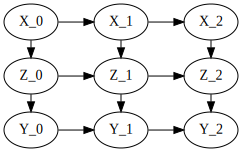

In [4]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, dag, exploration_sets, intervention_domain, true_objective_values  = setup_nonstat_scm(T=T)
dag_view

Unlike the DAG used for the STAT. example (figure 1 in paper) we need to modify the structure of this DAG to represent the non-stationary evolution of the SEM used in the example.

In [5]:
# Simple networkx syntax is used to manipulate an object
dag.add_edge('X_0','Z_1')
dag.add_edge('Z_1','Y_2')

# We print out the edge set just to make sure they have been properly added
dag.edges

OutMultiEdgeView([('X_0', 'Z_0', 0), ('X_0', 'X_1', 0), ('X_0', 'Z_1', 0), ('Z_0', 'Y_0', 0), ('Z_0', 'Z_1', 0), ('Y_0', 'Y_1', 0), ('X_1', 'Z_1', 0), ('X_1', 'X_2', 0), ('Z_1', 'Y_1', 0), ('Z_1', 'Z_2', 0), ('Z_1', 'Y_2', 0), ('Y_1', 'Y_2', 0), ('X_2', 'Z_2', 0), ('Z_2', 'Y_2', 0)])

The above DAG is the graphical structure we will be working with and is faithful to the one used in figure one in the paper. `dag` is a networkx object i.e.

In [6]:
type(dag)

networkx.classes.multidigraph.MultiDiGraph

and is the one we will use for exploring the optimization methods further down. `dag_view` is simply a convenient way to visualise the structure at hand and is just a string that we visulise using `pygraphviz`:

In [18]:
print(dag_view)

digraph { rankdir=LR; X_0 -> Z_0; Z_0 -> Y_0; X_1 -> Z_1; Z_1 -> Y_1; X_2 -> Z_2; Z_2 -> Y_2;  X_0 -> X_1; Z_0 -> Z_1; Y_0 -> Y_1; X_1 -> X_2; Z_1 -> Z_2; Y_1 -> Y_2;  { rank=same; X_0 Z_0 Y_0 } { rank=same; X_1 Z_1 Y_1 } { rank=same; X_2 Z_2 Y_2 }  }


**OBS. that the `dag_view` will not show our added edges as the object was generated before we modified the topology**

Notice that we make use of two types of structural equations models: `init_sem` and `sem`. The latter concerns interactions with the first time-slice in the DBN, which has no incoming edges from the previous time-slices, and is only active at $t=0$. For all other time-slices i.e. when $t>0$ the `sem` model is used.

After all of that we are now at liberty to sample the SEM.

In [7]:
# Number of independent samples (samples here are the time-series on the horizontal) per time-index
D_Obs = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=5, # How many samples we take per node in each time-slice
                                epsilon=None) # If we employ a noise model or not

D_Obs

{'X': array([[ 1.76405235,  2.16420955,  3.14294754],
        [ 0.4105985 ,  0.55464207,  2.00891558],
        [ 0.3130677 , -0.54102804, -3.09401785],
        [-0.18718385,  1.34559536,  2.81495413],
        [ 1.23029068,  2.43267053,  2.04534371]]),
 'Z': array([[ 4.00494555,  4.64566378,  6.81133344],
        [ 1.17163623, -0.05750244,  2.39527638],
        [ 0.9666863 ,  3.55927278, -0.27691009],
        [-0.03223642,  7.53455569,  9.46172408],
        [ 0.92798793, -2.09787866, -1.47255289]]),
 'Y': array([[  7.14338239,  -9.34724441,  11.40969522],
        [  7.33121891,  -5.89370655,   8.1413271 ],
        [  9.26966214, -10.06507592,   6.82847175],
        [  4.92974394,  -4.4613111 ,   6.54482845],
        [  5.29329765,  -5.34199947,   8.40277884]])}

The above observation samples contained in `D_obs` are sequential in the sense that the sample function generates each column per variable, conditional on the column samples at $t-1$.

## Other setup parameters 

In [14]:
# Contains the exploration sets we will be investigating
print(exploration_sets)
# The intervention domains for the manipulative variables
print(intervention_domain) 
# The true outcome values of Y given an optimal intervention on the three time-slices
print(["y^*_{} = {}".format(t,val) for t,val in enumerate(true_objective_values)])
# Number of trials
N = 10

[('X',), ('Z',), ('X', 'Z')]
{'X': [-4, 1], 'Z': [-3, 3]}
['y^*_0 = 4.3166247903554', 'y^*_1 = -8.329075657669375', 'y^*_2 = 12.387156465750184']


## Explore optimization methods

Unlike the demo in `stat_scm.ipynb` here we are going to demonstrate the replicate method as used to generate the results in the paper. In all these examples we do not employ any interventional data, just observational.

In [21]:
# See method for argument details
change_points = T*[False]
change_points[1] = True
results = run_methods_replicates(graph=dag, 
                                    sem=NonStationaryDependentSEM, 
                                    make_sem_hat = auto_sem_dependent_hat, 
                                    root_instrument=False,
                                    base_target_variable='Y',
                                    intervention_domain = intervention_domain, 
                                    methods_list = ['DCBO', 'CBO', 'ABO', 'BO'],
                                    obs_samples = None,
                                    exploration_sets = exploration_sets,
                                    total_timesteps = T,
                                    number_of_trials = N, 
                                    reps = 5,
                                    n_restart = 1,
                                    save_data = False,
                                    n_obs = 10,
                                    num_anchor_points = 100,
                                    sample_anchor_points = True,
                                    controlled_experiment=True,
                                    change_points=change_points)

Experiment count:   0%|          | 0/5 [00:00<?, ?it/s]


	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
 ../src/utils/sem_utils/toy_sems.py:158: RuntimeWarning:invalid value encountered in double_scalars
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.709725935236852
Optimization restart 1/1, f = 5.671133447774524
Optimization restart 1/1, f = 5.944357316009758


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 7.140823976520185
Optimization restart 1/1, f = 4.965699671391487


Optimization restart 1/1, f = 5.049220152680494


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 6.120809712062169
Optimization restart 1/1, f = 7.787410852684185
Optimization restart 1/1, f = 7.408869270530255
Optimization restart 1/1, f = 6.64403892807954
Optimization restart 1/1, f = 10.328745690209294


Optimization restart 1/1, f = 9.982123111284528


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 7.013337399166872
Optimization restart 1/1, f = 8.71452006136903
Optimization restart 1/1, f = 10.130437322967389
Optimization restart 1/1, f = 6.459679149647369
Optimization restart 1/1, f = 9.33242785576319


Time index: 100%|██████████| 3/3 [00:21<00:00,  7.21s/it]

Optimization restart 1/1, f = 11.842489396046677

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 9.502633635868555
Optimization restart 1/1, f = 9.35001468514117
Optimization restart 1/1, f = 5.789131830120601
Optimization restart 1/1, f = 8.044689263410058
Optimization restart 1/1, f = 7.1861577948127
Optimization restart 1/1, f = 6.687335022647204
Optimization restart 1/1, f = 4.946682295422846
Optimization restart 1/1, f = 3.7839744418375627
Optimization restart 1/1, f = 0.0950918391701272

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 39.51892257377118
Optimization restart 1/1, f = 42.260864326159336
Optimization restart 1/1, f = 43.80732060380305
Optimization restart 1/1, f = 43.028145791140965
Optimization restart 1/1, f = 47.004711516576045
Optimization restart 1/1, f = 49.97109016969686
Optimization restart 1/1, f = 51.70511778665271

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 54.64639934928736
Optimization restart 1/1, f = 57.659349558457386
Optimization restart 1/1, f = 70.3622483366307
Optimization restart 1/1, f = 73.46792351343055
Optimization restart 1/1, f = 76.98733041062081
Optimization restart 1/1, f = 81.2014138839288
Optimization restart 1/1, f = 84.94625902822993
Optimization restart 1/1, f = 88.51830980482971
Optimization restart 1/1, f = 91.43667662498677
Optimization restart 1/1, f = 94.97141261024669


Time index: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]


Optimization restart 1/1, f = 97.94930424209491

	>>>BO



reconstraining parameters GP_regression.rbf.variance


Time: 0
Optimization restart 1/1, f = 9.502633635868555
Optimization restart 1/1, f = 9.35001468514117
Optimization restart 1/1, f = 5.789131830120601
Optimization restart 1/1, f = 8.044689263410058
Optimization restart 1/1, f = 7.1861577948127
Optimization restart 1/1, f = 6.687335022647204
Optimization restart 1/1, f = 4.946682295422846
Optimization restart 1/1, f = 3.7839744418375627


Optimization restart 1/1, f = 0.0950918391701272


reconstraining parameters GP_regression.rbf.variance


Time: 1
Optimization restart 1/1, f = 5.69932077655892
Optimization restart 1/1, f = 6.631965034977608
Optimization restart 1/1, f = 8.429439565747554
Optimization restart 1/1, f = 13.106163755320843
Optimization restart 1/1, f = 18.389246473412243
Optimization restart 1/1, f = 20.04951973934862
Optimization restart 1/1, f = 23.12281197524544
Optimization restart 1/1, f = 29.40126373817995

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 31.647495804664327
Time: 2
Optimization restart 1/1, f = 14.64807401233823
Optimization restart 1/1, f = 22.000195188393448
Optimization restart 1/1, f = 23.67056928829456
Optimization restart 1/1, f = 25.936160178206084
Optimization restart 1/1, f = 26.859010387202304
Optimization restart 1/1, f = 30.071543958521666


Experiment count:  20%|██        | 1/5 [00:47<03:11, 47.87s/it]

Optimization restart 1/1, f = 32.24323217288348
Optimization restart 1/1, f = 34.74497127838251
Optimization restart 1/1, f = 36.899766728593626

	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.726198892126531
Optimization restart 1/1, f = 5.676557290189831
Optimization restart 1/1, f = 5.9904458578077655


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.928713344163141
Optimization restart 1/1, f = 3.107066799302636


Optimization restart 1/1, f = 7.1848744579704915


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 7.9187243015084965
Optimization restart 1/1, f = 7.00618477129275
Optimization restart 1/1, f = 7.464510490751724
Optimization restart 1/1, f = 7.992613860046257
Optimization restart 1/1, f = 11.975623536616125


Optimization restart 1/1, f = 10.648698098057704


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 6.50391525849625
Optimization restart 1/1, f = 7.187623327347894
Optimization restart 1/1, f = 8.073653592212123
Optimization restart 1/1, f = 8.690248073895958
Optimization restart 1/1, f = 10.055428583852006


Time index: 100%|██████████| 3/3 [00:20<00:00,  6.98s/it]

Optimization restart 1/1, f = 11.145511455760019

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 9.371452523501937
Optimization restart 1/1, f = 10.066560757247888
Optimization restart 1/1, f = 10.889780970777846
Optimization restart 1/1, f = 12.766959106812587
Optimization restart 1/1, f = 11.25604031984731
Optimization restart 1/1, f = 10.616428812705248
Optimization restart 1/1, f = 6.458279868977906
Optimization restart 1/1, f = 3.202166337549773
Optimization restart 1/1, f = 3.9959563663648243

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 42.19314473485852
Optimization restart 1/1, f = 43.48205316831499
Optimization restart 1/1, f = 45.25836779400599
Optimization restart 1/1, f = 49.94712854526963
Optimization restart 1/1, f = 53.495769567994614
Optimization restart 1/1, f = 55.44131634497219
Optimization restart 1/1, f = 58.27721116111331

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 60.15040532279383
Optimization restart 1/1, f = 62.54578927797177
Optimization restart 1/1, f = 73.3895380824113
Optimization restart 1/1, f = 78.34348930927322
Optimization restart 1/1, f = 81.95219758742924
Optimization restart 1/1, f = 85.29545419806475


Time index: 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


Optimization restart 1/1, f = 88.45540098205973
Optimization restart 1/1, f = 92.23462373123544
Optimization restart 1/1, f = 96.20974540259847
Optimization restart 1/1, f = 99.7629431114118
Optimization restart 1/1, f = 103.36648992814493

	>>>BO



reconstraining parameters GP_regression.rbf.variance


Time: 0
Optimization restart 1/1, f = 9.371452523501937
Optimization restart 1/1, f = 10.066560757247888
Optimization restart 1/1, f = 10.889780970777846
Optimization restart 1/1, f = 12.766959106812587
Optimization restart 1/1, f = 11.25604031984731
Optimization restart 1/1, f = 10.616428812705248
Optimization restart 1/1, f = 6.458279868977906
Optimization restart 1/1, f = 3.202166337549773


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.9959563663648243
Time: 1
Optimization restart 1/1, f = 10.343028725740917
Optimization restart 1/1, f = 12.00479451602694
Optimization restart 1/1, f = 13.66231743775395
Optimization restart 1/1, f = 17.03434951249775
Optimization restart 1/1, f = 20.015108453933188
Optimization restart 1/1, f = 21.39514777817615
Optimization restart 1/1, f = 23.470651213227036
Optimization restart 1/1, f = 24.766998403445367
Optimization restart 1/1, f = 27.8879963992886

reconstraining parameters GP_regression.rbf.variance



Time: 2
Optimization restart 1/1, f = 9.419804859411562
Optimization restart 1/1, f = 14.597868660132
Optimization restart 1/1, f = 17.253104036938797
Optimization restart 1/1, f = 20.261762991435056
Optimization restart 1/1, f = 23.111430888634892
Optimization restart 1/1, f = 24.145718010740765
Optimization restart 1/1, f = 24.796801184677484
Optimization restart 1/1, f = 26.498846304573306
Optimization restart 1/1, f = 25.972697390116267


Experiment count:  40%|████      | 2/5 [01:35<02:23, 47.77s/it]


	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.636371607739999
Optimization restart 1/1, f = 5.694220166492334
Optimization restart 1/1, f = 6.005663271663826


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 3.984754354773667
Optimization restart 1/1, f = 7.294088528404245


Optimization restart 1/1, f = 5.910231203611942


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 8.093073081832765
Optimization restart 1/1, f = 6.813287679322762
Optimization restart 1/1, f = 6.747784756967654
Optimization restart 1/1, f = 11.458991639438615
Optimization restart 1/1, f = 9.981731507420355


Optimization restart 1/1, f = 11.327953603297162


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/GPy/core/parameterization/priorizable.py:81: RuntimeWarning:overflow encountered in double_scalars


Optimization restart 1/1, f = 6.998410875089691
Optimization restart 1/1, f = 6.480605693805245
Optimization restart 1/1, f = 7.337289179812959
Optimization restart 1/1, f = 7.240061490863864
Optimization restart 1/1, f = 6.677459359664505


Time index: 100%|██████████| 3/3 [00:21<00:00,  7.09s/it]

Optimization restart 1/1, f = 8.102367872478666

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 9.5106357281513
Optimization restart 1/1, f = 9.892597310926494
Optimization restart 1/1, f = 11.891887377886203
Optimization restart 1/1, f = 10.821371630753678
Optimization restart 1/1, f = 10.845729449459164
Optimization restart 1/1, f = 10.394540358225619
Optimization restart 1/1, f = 9.782237085466257
Optimization restart 1/1, f = 7.336732226253941
Optimization restart 1/1, f = 4.374998847189831


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 43.93042767888271
Optimization restart 1/1, f = 47.29145957440801

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 49.85230307815756
Optimization restart 1/1, f = 51.7346756844963
Optimization restart 1/1, f = 53.994240002474065
Optimization restart 1/1, f = 57.40872192722287
Optimization restart 1/1, f = 60.96345921269303
Optimization restart 1/1, f = 62.12041759437943
Optimization restart 1/1, f = 63.78510559237134
Optimization restart 1/1, f = 80.90260263755683


Time index: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Optimization restart 1/1, f = 86.0871397058698
Optimization restart 1/1, f = 91.47986857809505
Optimization restart 1/1, f = 95.80025609005581
Optimization restart 1/1, f = 101.14841906491893
Optimization restart 1/1, f = 106.22798229006388
Optimization restart 1/1, f = 110.75315714076218
Optimization restart 1/1, f = 115.08082363000838
Optimization restart 1/1, f = 118.12988597117932

	>>>BO



reconstraining parameters GP_regression.rbf.variance


Time: 0
Optimization restart 1/1, f = 9.5106357281513
Optimization restart 1/1, f = 9.892597310926494
Optimization restart 1/1, f = 11.891887377886203
Optimization restart 1/1, f = 10.821371630753678


Optimization restart 1/1, f = 10.845729449459164
Optimization restart 1/1, f = 10.394540358225619
Optimization restart 1/1, f = 9.782237085466257
Optimization restart 1/1, f = 7.336732226253941
Optimization restart 1/1, f = 4.374998847189831
Time: 1


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 6.563210246869021
Optimization restart 1/1, f = 9.918238528773564
Optimization restart 1/1, f = 11.260474176777961
Optimization restart 1/1, f = 18.613549061583385
Optimization restart 1/1, f = 20.901417430464058
Optimization restart 1/1, f = 24.050388458436363

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 26.26717388131077
Optimization restart 1/1, f = 28.415947203028107
Optimization restart 1/1, f = 31.879503143130904
Time: 2
Optimization restart 1/1, f = 10.530970652799525
Optimization restart 1/1, f = 12.787864809774236
Optimization restart 1/1, f = 16.209720122864947
Optimization restart 1/1, f = 17.196038320849492
Optimization restart 1/1, f = 22.596165205032435
Optimization restart 1/1, f = 23.083045837839936
Optimization restart 1/1, f = 24.760494005820032

Experiment count:  60%|██████    | 3/5 [02:22<01:35, 47.51s/it]


Optimization restart 1/1, f = 24.155586575290418
Optimization restart 1/1, f = 23.291510991281985

	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.722680872821749
Optimization restart 1/1, f = 5.664936854743708
Optimization restart 1/1, f = 5.921228789148438
Optimization restart 1/1, f = 7.191132939732575


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 2.5557595762788896


Optimization restart 1/1, f = 5.2151719155164065


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 7.231872295514203
Optimization restart 1/1, f = 7.012225238504419
Optimization restart 1/1, f = 7.2286626545964205
Optimization restart 1/1, f = 11.575691181529248
Optimization restart 1/1, f = 13.081009520780492


Optimization restart 1/1, f = 8.688257048150364


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 7.001623988727008
Optimization restart 1/1, f = 6.589894733920505
Optimization restart 1/1, f = 7.059214396514976
Optimization restart 1/1, f = 7.03919172297552
Optimization restart 1/1, f = 6.141572510676695


Time index: 100%|██████████| 3/3 [00:21<00:00,  7.06s/it]

Optimization restart 1/1, f = 7.59136828773361

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 9.545152816863425
Optimization restart 1/1, f = 10.20929221208144
Optimization restart 1/1, f = 11.764535287640784
Optimization restart 1/1, f = 10.990706922066181
Optimization restart 1/1, f = 12.318762941348187
Optimization restart 1/1, f = 11.452187891058436
Optimization restart 1/1, f = 9.594899398377212
Optimization restart 1/1, f = 8.505269778744456
Optimization restart 1/1, f = 6.096061905154442

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 43.574551501365434
Optimization restart 1/1, f = 46.16211768010687
Optimization restart 1/1, f = 48.552857260936776
Optimization restart 1/1, f = 50.75284596353411
Optimization restart 1/1, f = 52.30418674349427
Optimization restart 1/1, f = 53.21813144024024


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 54.64813219628532
Optimization restart 1/1, f = 60.028051949089026
Optimization restart 1/1, f = 61.578203499653625
Optimization restart 1/1, f = 77.01560343057794
Optimization restart 1/1, f = 81.96370858183445
Optimization restart 1/1, f = 87.5073571885649
Optimization restart 1/1, f = 91.69317954134465


Time index: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


Optimization restart 1/1, f = 96.50934543632474
Optimization restart 1/1, f = 100.25228339837794
Optimization restart 1/1, f = 104.1443872276287
Optimization restart 1/1, f = 107.62355074593881
Optimization restart 1/1, f = 112.50709834209404

	>>>BO



reconstraining parameters GP_regression.rbf.variance


Time: 0
Optimization restart 1/1, f = 9.545152816863425
Optimization restart 1/1, f = 10.20929221208144
Optimization restart 1/1, f = 11.764535287640784


Optimization restart 1/1, f = 10.990706922066181
Optimization restart 1/1, f = 12.318762941348187
Optimization restart 1/1, f = 11.452187891058436
Optimization restart 1/1, f = 9.594899398377212
Optimization restart 1/1, f = 8.505269778744456
Optimization restart 1/1, f = 6.096061905154442
Time: 1


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 9.16373142383809
Optimization restart 1/1, f = 11.546277707655351
Optimization restart 1/1, f = 13.269202923725615
Optimization restart 1/1, f = 15.366066330073718
Optimization restart 1/1, f = 17.71849446887473
Optimization restart 1/1, f = 19.39778416651424

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 21.105914288677567
Optimization restart 1/1, f = 21.563471975647456
Optimization restart 1/1, f = 22.543855570967295
Time: 2
Optimization restart 1/1, f = 10.700494023833466
Optimization restart 1/1, f = 10.879118582479162
Optimization restart 1/1, f = 17.342000762630377
Optimization restart 1/1, f = 20.214422046574242
Optimization restart 1/1, f = 21.48751131237151


 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /Users/nd/anaconda3/envs/scibo/lib/python3.7/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1
Experiment count:  80%|████████  | 4/5 [03:10<00:47, 47.42s/it]

Optimization restart 1/1, f = 24.059488395030804
Optimization restart 1/1, f = 24.947944650364743
Optimization restart 1/1, f = 25.614726882427274
Optimization restart 1/1, f = 26.247000036605627

	>>>DCBO



reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 4.721773734200967
Optimization restart 1/1, f = 5.543784738914605
Optimization restart 1/1, f = 5.507998725001019


reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 5.524019668647023
Optimization restart 1/1, f = 7.075728910299045


Optimization restart 1/1, f = 4.517268507767707


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 9.707452279585201
Optimization restart 1/1, f = 6.882134488861222
Optimization restart 1/1, f = 7.1077745849203815
Optimization restart 1/1, f = 11.761953977262923
Optimization restart 1/1, f = 11.62886390123755


Optimization restart 1/1, f = 14.420959416719624


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 6.7271243812421
Optimization restart 1/1, f = 6.4536165482616745
Optimization restart 1/1, f = 8.07207593069126
Optimization restart 1/1, f = 7.123219332380407
Optimization restart 1/1, f = 7.343922107713237


Time index: 100%|██████████| 3/3 [00:25<00:00,  8.47s/it]

Optimization restart 1/1, f = 7.333551548800104

	>>>CBO




reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.v


	>>>ABO



reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/1, f = 9.368518283583665
Optimization restart 1/1, f = 9.84872921294648
Optimization restart 1/1, f = 8.769315632726482
Optimization restart 1/1, f = 10.861126680499549
Optimization restart 1/1, f = 9.94800557024222
Optimization restart 1/1, f = 9.720639017774978
Optimization restart 1/1, f = 9.763906692793848
Optimization restart 1/1, f = 6.284883716657562

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 4.641921033741104
Optimization restart 1/1, f = 42.16666231487883
Optimization restart 1/1, f = 43.63742893680532
Optimization restart 1/1, f = 44.941389490313284
Optimization restart 1/1, f = 48.296553735217906
Optimization restart 1/1, f = 50.46422567370376
Optimization restart 1/1, f = 49.89916666517115
Optimization restart 1/1, f = 51.763527423718045

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 55.911951484733926
Optimization restart 1/1, f = 62.38861994909405
Optimization restart 1/1, f = 71.83441827780916
Optimization restart 1/1, f = 75.57613979652525
Optimization restart 1/1, f = 79.4818796949152
Optimization restart 1/1, f = 83.41754152882773


Time index: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


Optimization restart 1/1, f = 87.44662864790912
Optimization restart 1/1, f = 91.16159249537266
Optimization restart 1/1, f = 94.83903558087972
Optimization restart 1/1, f = 98.0812632694954
Optimization restart 1/1, f = 102.04872550750116

	>>>BO



reconstraining parameters GP_regression.rbf.variance


Time: 0
Optimization restart 1/1, f = 9.368518283583665
Optimization restart 1/1, f = 9.84872921294648
Optimization restart 1/1, f = 8.769315632726482
Optimization restart 1/1, f = 10.861126680499549
Optimization restart 1/1, f = 9.94800557024222
Optimization restart 1/1, f = 9.720639017774978
Optimization restart 1/1, f = 9.763906692793848
Optimization restart 1/1, f = 6.284883716657562

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 4.641921033741104
Time: 1
Optimization restart 1/1, f = 6.3303081820159415
Optimization restart 1/1, f = 7.6042236227201006
Optimization restart 1/1, f = 9.33304515302783
Optimization restart 1/1, f = 10.813080089232152
Optimization restart 1/1, f = 11.478103458184066
Optimization restart 1/1, f = 11.334946566421836
Optimization restart 1/1, f = 10.164251777850783
Optimization restart 1/1, f = 13.159334037627257

reconstraining parameters GP_regression.rbf.variance



Optimization restart 1/1, f = 15.161093423511103
Time: 2
Optimization restart 1/1, f = 10.986702453553123
Optimization restart 1/1, f = 15.48942925359431
Optimization restart 1/1, f = 20.6888278789871
Optimization restart 1/1, f = 22.553535053542053
Optimization restart 1/1, f = 23.7778379336653
Optimization restart 1/1, f = 24.547188424324442
Optimization restart 1/1, f = 27.075538918323407

Experiment count: 100%|██████████| 5/5 [04:03<00:00, 48.79s/it]


Optimization restart 1/1, f = 27.303030429113903
Optimization restart 1/1, f = 27.58181158229906
